In [1]:
import os, sys, re
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import torch
import torchcde
import h5py
sys.path.append(os.path.dirname(os.getcwd()))

In [2]:
eventid_list = np.array([
    # Planet/Binary
    '0328', '0570', '1196', '1860', '1914', 
    # Binary/Plan
    '0002', '0104', '0143', '0149', '0182',
    '0308', '0681', '0724', '1187', '1713',
    '2270', '2485', '3199', 
    # Binary
    '0021', '0200', '0209', '0236', '0270',
    '0325', '0335', '0342', '0343', '0386',
    '0412', '0535', '0561', '0609', '0649',
    '0651', '0787', '0819', '0967', '1182',
    '1195', '1281', '1291', '1334', '1363',
    '1524', '1576', '1679', '1686', '1689',
    '1700', '1722', '1850', '1984', '2063',
    '2142', '2279', '2286', '2298', '2309',
    '2324', '2496', '2596', '2599', '2655',
    '2667', '2769', '2840', '2842', '2888',
    ])

In [3]:
q = torch.tensor([
    # Planet/Binary
    0.4270, np.nan, 0.2342, np.nan, 0.234,
    # Binary/Plan
    np.nan, np.nan, 0.0367, 0.0480, np.nan,
    np.nan, np.nan, 0.1448, 0.1284, np.nan,
    0.1734, 0.4270, np.nan,
    # Binary
    0.234, 0.356, 0.0722, 0.50, 0.234, 
    0.169, 0.0461, 0.4062, 0.316, 0.19, 
    0.594, np.nan, np.nan, 0.3675, 0.2342,
    0.945, 0.576, 0.532, np.nan, 0.457,
    0.0951, 0.904, 0.3675, 0.3554, 0.721,
    0.4962, 0.110, 0.7786, 0.4199, 0.4962,
    0.8809, 0.730, 0.7357, 0.152, 0.5766,
    0.1492, 0.4270, 0.9607, 0.0858, 0.7555,
    np.nan, 0.6700, 0.693, 0.231, 0.55844,
    0.4962, 0.081, 0.7405, 0.6700, 0.2015,
])

In [4]:
s = torch.tensor([
    # Planet/Binary
    0.3325, np.nan, 0.2084, np.nan, 0.434,
    # Binary/Plan
    np.nan, np.nan, 0.946, 0.496, np.nan,
    np.nan, 1.010, 2.6540, 7.1626, np.nan,
    4.799, 6.2676, np.nan,
    # Binary
    3.674, 0.419, 0.49, 0.61, 6.700,
    1.086, 0.8625, 0.5430, 0.530, 1.10,
    2.049, np.nan, np.nan, 0.4342, 3.6747,
    1.304, 0.648, 1.9781, np.nan, 0.836,
    1.6496, 3.007, 1.7635, 0.8117, 2.858,
    3.2155, 2.015, 0.3554, 2.3031, 2.4621,
    1.5649, 0.596, 1.3634, 0.977, 3.0079,
    0.2084, 0.6480, 1.0780, 0.4847, 1.4483,
    np.nan, 0.332, 1.010, 0.898, 0.6555,
    1.1053, 0.406, 2.3733, 3.4374, 1.2887, 
])

In [5]:
targetdir = '/work/hmzhao/KMT_data/'
with h5py.File(targetdir + 'processed_data.h5', mode='r') as dataset_file:
    X_even = torch.tensor(dataset_file['X'][...]).float()
nanind = torch.where(~torch.isnan(q))[0]
eventid_list = eventid_list[nanind]
q = q[nanind]
s = s[nanind]
X_even = X_even[nanind]
nanind = torch.where(~torch.isnan(s))[0]
eventid_list = eventid_list[nanind]
q = q[nanind]
s = s[nanind]
X_even = X_even[nanind]
nanind = torch.where(s > 0.3)[0]
eventid_list = eventid_list[nanind]
q = q[nanind]
s = s[nanind]
X_even = X_even[nanind]
nanind = torch.where(s < 3)[0]
eventid_list = eventid_list[nanind]
q = q[nanind]
s = s[nanind]
X_even = X_even[nanind]
# nanind = torch.where(torch.max(X_even[:, :, 1], dim=1).values - torch.min(X_even[:, :, 1], dim=1).values > 2)[0]
# eventid_list = eventid_list[nanind]
# q = q[nanind]
# s = s[nanind]
# X_even = X_even[nanind]
# nanind = torch.where(torch.max(X_even[:, :, 0], dim=1).values > 1)[0]
# eventid_list = eventid_list[nanind]
# q = q[nanind]
# s = s[nanind]
# X_even = X_even[nanind]
# nanind = torch.where(torch.min(X_even[:, :, 0], dim=1).values < - 1)[0]
# eventid_list = eventid_list[nanind]
# q = q[nanind]
# s = s[nanind]
# X_even = X_even[nanind]
train_coeffs = torchcde.hermite_cubic_coefficients_with_backward_differences(X_even)
print(len(train_coeffs))

43


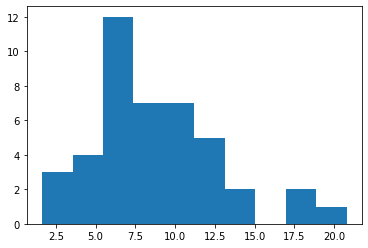

In [6]:
plt.hist((torch.max(X_even[:, :, 1], dim=1).values - torch.min(X_even[:, :, 1], dim=1).values).numpy())
plt.show()

In [7]:
from model.cde_mdn import CDE_MDN

device = torch.device("cuda:7" if torch.cuda.is_available() else "cpu")

checkpt = torch.load('/work/hmzhao/experiments/cde_mdn/experiment_2.ckpt', map_location='cpu')
ckpt_args = checkpt['args']
state_dict = checkpt['state_dict']

output_dim = 6
input_dim = X_even.shape[-1]
latent_dim = ckpt_args.latents

model = CDE_MDN(input_dim, latent_dim, output_dim).to(device)
model_dict = model.state_dict()

# 1. filter out unnecessary keys
state_dict = {k: v for k, v in state_dict.items() if k in model_dict}
# 2. overwrite entries in the existing state dict
model_dict.update(state_dict) 
# 3. load the new state dict
model.load_state_dict(state_dict)
model.to(device)

CDE_MDN(
  (cde_func): CDEFunc(
    (linear1): Linear(in_features=32, out_features=1024, bias=True)
    (relu1): PReLU(num_parameters=1)
    (resblocks): Sequential(
      (0): ResBlock(
        (linear1): Linear(in_features=1024, out_features=1024, bias=True)
        (nonlinear1): PReLU(num_parameters=1)
        (linear2): Linear(in_features=1024, out_features=1024, bias=True)
      )
      (1): ResBlock(
        (linear1): Linear(in_features=1024, out_features=1024, bias=True)
        (nonlinear1): PReLU(num_parameters=1)
        (linear2): Linear(in_features=1024, out_features=1024, bias=True)
      )
      (2): ResBlock(
        (linear1): Linear(in_features=1024, out_features=1024, bias=True)
        (nonlinear1): PReLU(num_parameters=1)
        (linear2): Linear(in_features=1024, out_features=1024, bias=True)
      )
    )
    (relu2): PReLU(num_parameters=1)
    (linear2): Linear(in_features=1024, out_features=160, bias=True)
    (tanh): Tanh()
    (linear3): Linear(in_features=

In [8]:
def get_negloglik(pi, normal, y):
    normal = torch.distributions.Normal(normal.loc[:, :, [2]], normal.scale[:, :, [2]])
    loglik = normal.log_prob(y.unsqueeze(1).expand_as(normal.loc))
    loglik = torch.sum(loglik, dim=2)
    loss = -torch.logsumexp(torch.log(pi.probs) + loglik, dim=1)
    return loss


num = len(X_even)
batchsize = len(X_even)
pred = torch.zeros((num, output_dim))
nll = torch.zeros((num,))
nll_sample = torch.zeros((num,))
model.eval()
for i in tqdm(range(num // batchsize)):
    torch.cuda.empty_cache()
    batch = train_coeffs[i*batchsize:i*batchsize+batchsize].float().to(device)
    # pred[i*batchsize:i*batchsize+batchsize] = model(batch).detach().cpu()
    pi, normal = model(batch)
    pred[i*batchsize:i*batchsize+batchsize] = model.sample(pi, normal).detach().cpu()
    nll[i*batchsize:i*batchsize+batchsize] = get_negloglik(pi, normal, torch.log10(q).reshape(-1, 1)[i*batchsize:i*batchsize+batchsize].float().to(device)).detach().cpu()
    nll_sample[i*batchsize:i*batchsize+batchsize] = get_negloglik(pi, normal, pred[i*batchsize:i*batchsize+batchsize, [2]].float().to(device)).detach().cpu()

  0%|          | 0/1 [00:00<?, ?it/s]

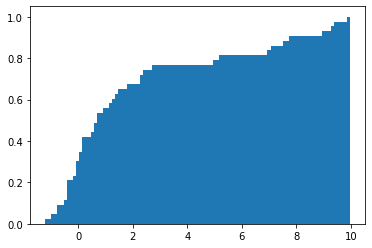

In [9]:
plt.hist(nll.numpy(), bins=100, density=True, cumulative=True)
plt.show()

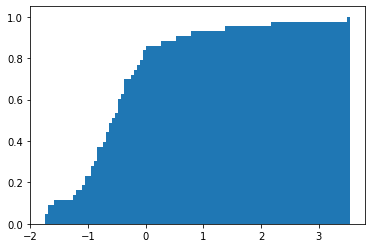

In [10]:
plt.hist(nll_sample.numpy(), bins=100, density=True, cumulative=True)
plt.show()

In [11]:
10**pred[:, 2]


tensor([0.1296, 0.3444, 0.3639, 0.0092, 0.7409, 0.2974, 0.4856, 0.3102, 0.5604,
        0.5069, 0.2452, 0.6736, 0.3016, 0.2047, 0.2466, 0.2253, 1.7471, 0.5322,
        0.8561, 0.2669, 0.4464, 0.3233, 0.5942, 0.2276, 1.8737, 0.5859, 0.6048,
        1.5001, 0.3602, 0.9564, 0.5122, 0.3017, 0.6879, 0.4685, 0.6573, 0.4974,
        0.1724, 0.6884, 0.8415, 0.6212, 0.8214, 0.3983, 0.0067])

In [12]:
q

tensor([0.4270, 0.2340, 0.0367, 0.0480, 0.1448, 0.3560, 0.0722, 0.5000, 0.1690,
        0.0461, 0.4062, 0.3160, 0.1900, 0.5940, 0.3675, 0.9450, 0.5760, 0.5320,
        0.4570, 0.0951, 0.3675, 0.3554, 0.7210, 0.1100, 0.7786, 0.4199, 0.4962,
        0.8809, 0.7300, 0.7357, 0.1520, 0.4270, 0.9607, 0.0858, 0.7555, 0.6700,
        0.6930, 0.2310, 0.5584, 0.4962, 0.0810, 0.7405, 0.2015])

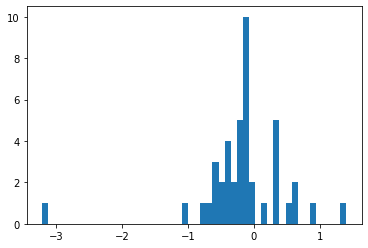

In [13]:
plt.hist(np.log10(np.abs(((pred[:, 2] - torch.log10(q))/torch.log10(q)).numpy())), bins=50)
plt.show()

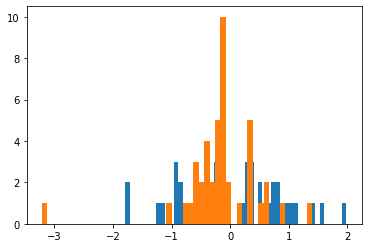

In [14]:
plt.hist(np.log10(np.abs(((torch.rand(len(q))*(-2) - torch.log10(q))/torch.log10(q)).numpy())), bins=50)
plt.hist(np.log10(np.abs(((pred[:, 2] - torch.log10(q))/torch.log10(q)).numpy())), bins=50)
plt.show()

In [15]:
np.sum(np.abs(((pred[:, 2] - torch.log10(q))/torch.log10(q))).numpy() < 1)/len(q)

0.7441860465116279

In [16]:
np.sum(np.abs(((torch.rand(len(q))*(-2) - torch.log10(q))/torch.log10(q))).numpy() < 1)/len(q)

0.4418604651162791

In [17]:
torch.mean((pred[:, 2] - torch.log10(q))**2)

tensor(0.2548)

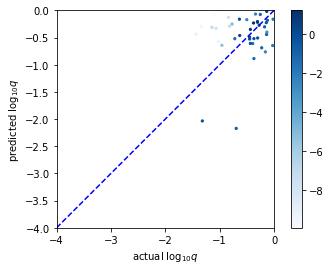

tensor([-0.2530, -0.3043, -1.0915, -0.1305, -0.6957])
[-0.0749564  -0.20676664 -0.08545146 -0.39979324 -2.1713037 ]
mse of log10q:  0.2548248767852783


In [18]:
import matplotlib.pyplot as plt
%matplotlib inline
# num=4096
plt.axis('square')
plt.xlim(-4, 0)
plt.ylim(-4, 0)
plt.xlabel(r'actual $\log_{10}q$')
plt.ylabel(r'predicted $\log_{10}q$')
plt.scatter(torch.log10(q), pred.numpy()[:, 2], s=5, c=-nll, cmap='Blues')
plt.plot(np.linspace(-4, 0), np.linspace(-4, 0), color='b', linestyle='dashed')
plt.colorbar()
plt.show()
print(torch.log10(q)[-5:])
print(pred.numpy()[-5:, 2])
print('mse of log10q: ', torch.mean((torch.log10(q) -  pred.numpy()[:, 2])**2, dim=0).detach().cpu().item())

In [19]:
((torch.log10(q) -  pred.numpy()[:, 2])**2).argmax()

tensor(42)

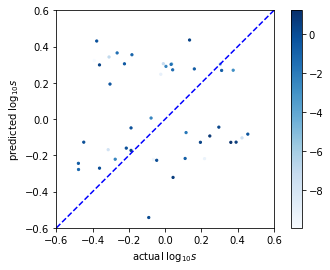

tensor([-0.1834,  0.0435, -0.3915,  0.3754,  0.1102])
[ 0.35500747 -0.32191297  0.32307005  0.26968333 -0.21733576]
mse of log10s:  0.14461550116539001


In [20]:
import matplotlib.pyplot as plt
%matplotlib inline
# num=4096
plt.axis('square')
plt.xlim(-0.6, 0.6)
plt.ylim(-0.6, 0.6)
plt.xlabel(r'actual $\log_{10}s$')
plt.ylabel(r'predicted $\log_{10}s$')
plt.scatter(torch.log10(s), pred.numpy()[:, 3], s=5, c=-nll, cmap='Blues')
plt.plot(np.linspace(-0.6, 0.6), np.linspace(-0.6, 0.6), color='b', linestyle='dashed')
plt.colorbar()
plt.show()
print(torch.log10(s)[-5:])
print(pred.numpy()[-5:, 3])
print('mse of log10s: ', torch.mean((torch.log10(s) -  pred.numpy()[:, 3])**2, dim=0).detach().cpu().item())

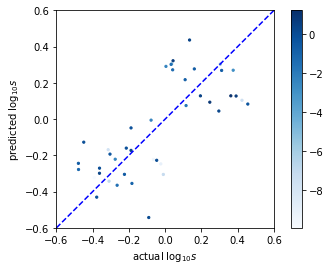

tensor([-0.1834,  0.0435, -0.3915,  0.3754,  0.1102])
[-0.35500747  0.32191297 -0.32307005  0.26968333  0.21733576]
mse of log10s:  0.03895598225715648


In [21]:
import matplotlib.pyplot as plt
%matplotlib inline
# num=4096
plt.axis('square')
plt.xlim(-0.6, 0.6)
plt.ylim(-0.6, 0.6)
plt.xlabel(r'actual $\log_{10}s$')
plt.ylabel(r'predicted $\log_{10}s$')
plt.scatter(np.log10(s), pred.numpy()[:, 3] * (2 * (np.log10(s.numpy()) * (pred.numpy()[:, 3]) > 0) - 1), s=5, c=-nll, cmap='Blues')
plt.plot(np.linspace(-0.6, 0.6), np.linspace(-0.6, 0.6), color='b', linestyle='dashed')
plt.colorbar()
plt.show()
print(torch.log10(s)[-5:])
print((pred.numpy()[:, 3] * (2 * (np.log10(s.numpy()) * (pred.numpy()[:, 3]) > 0) - 1))[-5:])
print('mse of log10s: ', torch.mean((torch.log10(s) -  pred.numpy()[:, 3] * (2 * (np.log10(s.numpy()) * (pred.numpy()[:, 3]) > 0) - 1))**2, dim=0).detach().cpu().item())

0236
tensor(0.5000) tensor(0.3102)
tensor(0.6100) tensor(0.6915)


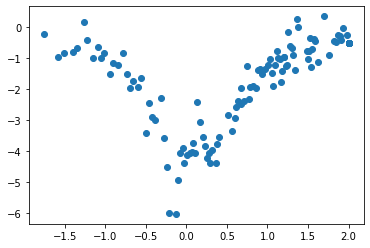

In [190]:
num = 7
print(eventid_list[num])
print(q[num], 10**pred[num, 2])
print(s[num], 10**pred[num, 3])
plt.scatter(X_even[num, :, 0], X_even[num, :, 1])
plt.show()

In [191]:
# train_coeffs = torchcde.hermite_cubic_coefficients_with_backward_differences(X_even[[num], :-120])

In [192]:
pi, normal = model(train_coeffs[[num]].float().to(device))

In [193]:
sample = model.sample(pi, normal).cpu().numpy()
print(sample)
print(torch.log10(q[num]), torch.log10(s[num]))

[[ 0.41814035 -2.581552   -0.590317   -0.08289254  0.572801   -0.02817312]]
tensor(-0.3010) tensor(-0.2147)


In [194]:
# qsnormal = torch.distributions.Normal(normal.loc[:, :, [0, 3]], normal.scale[:, :, [0, 3]])
qsnormal = torch.distributions.Normal(normal.loc[:, :, [2, 3]], normal.scale[:, :, [2, 3]])
grid = torch.stack(torch.meshgrid(torch.linspace(-4, 0, 100), torch.linspace(-0.6, 0.6, 100)), dim=-1).reshape(-1, 2)
# grid = torch.stack(torch.meshgrid(torch.linspace(0, 1, 100), torch.linspace(-0.6, 0.6, 100)), dim=-1).reshape(-1, 2)
prob = torch.zeros(10000, 1)
# y = torch.tile(Y[[num]], [10000, 1])
# y[:, 2:4] = grid
for i in tqdm(range(10000)):
    prob[i] = torch.exp(-model.mdn_loss(pi, qsnormal, grid[[i]].to(device)).detach().cpu())

  0%|          | 0/10000 [00:00<?, ?it/s]

In [195]:
torch.exp(-get_negloglik(pi, normal, torch.log10(q)[[num]].to(device))).detach().cpu(), \
torch.exp(-get_negloglik(pi, normal, model.sample(pi, normal)[:, 2].to(device)).detach().cpu()), \
torch.exp(-model.mdn_loss(pi, normal, model.sample(pi, normal).to(device)).detach().cpu())

(tensor([0.9405]), tensor([1.7739]), tensor(171.8517))

tensor(-0.3010) tensor(-0.2147)
[[ 0.36005005 -3.403223   -0.4515778  -0.1540744   0.65722734 -0.0968851 ]]


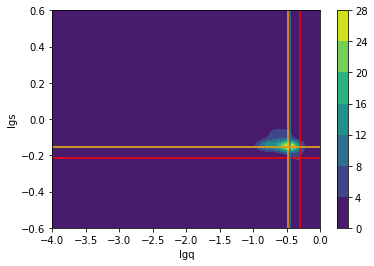

In [204]:
sample = model.sample(pi, normal).detach().cpu().numpy()
x, y = torch.meshgrid(torch.linspace(-4, 0, 100), torch.linspace(-0.6, 0.6, 100))
plt.xlabel('lgq'); plt.ylabel('lgs')
# x, y = torch.meshgrid(torch.linspace(0, 1, 100), torch.linspace(-0.6, 0.6, 100))
plt.contourf(x, y, prob.reshape(100, 100))
# plt.contourf(torch.linspace(0, 1, 100), torch.linspace(-0.6, 0.6, 100), prob.reshape(100, 100).T)
plt.hlines(np.log10(s[num]), -4, 0, colors='red')
plt.vlines(np.log10(q[num]), -0.6, 0.6, colors='red')
# plt.hlines(sample[0, 3], 0, 1)
# plt.vlines(sample[0, 0], -0.6, 0.6)
plt.hlines(sample[0, 3], -4, 0)
plt.vlines(sample[0, 2], -0.6, 0.6)
plt.colorbar()
print(torch.log10(q)[num], torch.log10(s)[num])
print(sample)
plt.hlines(torch.linspace(-0.6, 0.6, 100)[prob.argmax().item()%100], -4, 0, color='orange')
plt.vlines(torch.linspace(-4, 0, 100)[prob.argmax().item()//100], -0.6, 0.6, color='orange')
plt.show()

In [210]:
qsnormal = torch.distributions.Normal(normal.loc[:, :, [0, -2]], normal.scale[:, :, [0, -2]])
grid = torch.stack(torch.meshgrid(torch.linspace(0, 1, 100), torch.linspace(0, 2, 100)), dim=-1).reshape(-1, 2)
# grid = torch.stack(torch.meshgrid(torch.linspace(0, 1, 100), torch.linspace(-0.6, 0.6, 100)), dim=-1).reshape(-1, 2)
prob = torch.zeros(10000, 1)
# y = torch.tile(Y[[num]], [10000, 1])
# y[:, 2:4] = grid
for i in tqdm(range(10000)):
    prob[i] = torch.exp(-model.mdn_loss(pi, qsnormal, grid[[i]].to(device)).detach().cpu())

  0%|          | 0/10000 [00:00<?, ?it/s]

[[ 0.30490157 -3.6708117  -0.3183896  -0.13056085  0.68219906 -0.1285442 ]]


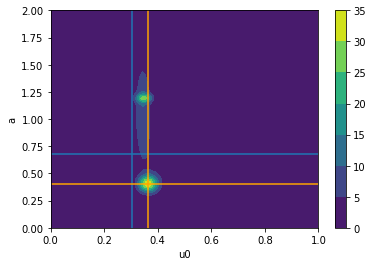

In [219]:
sample = model.sample(pi, normal).detach().cpu().numpy()
x, y = torch.meshgrid(torch.linspace(0, 1, 100), torch.linspace(0, 2, 100))
plt.xlabel('u0'); plt.ylabel('a')
# x, y = torch.meshgrid(torch.linspace(0, 1, 100), torch.linspace(-0.6, 0.6, 100))
plt.contourf(x, y, prob.reshape(100, 100))
plt.hlines(sample[0, -2], 0, 1)
plt.vlines(sample[0, 0], 0, 2)
plt.colorbar()
print(sample)
plt.hlines(torch.linspace(0, 2, 100)[prob.argmax().item()%100], 0, 1, color='orange')
plt.vlines(torch.linspace(0, 1, 100)[prob.argmax().item()//100], 0, 2, color='orange')
plt.show()

In [220]:
sample[0, 0], 10**sample[0, 1], 10**sample[0, 2], 10**sample[0, 3], sample[0, 4]*np.pi, 10**sample[0, 5]

(0.30490157,
 0.00021339701826672346,
 0.48040819309479266,
 0.7403535358364371,
 2.143191558062391,
 0.7437993654425611)

In [221]:
import MulensModel as mm
# sample = model.sample(pi, normal).detach().cpu().numpy()
fs = 10**sample[0, 5]
parameters = { # 1196
        't_0': 0,
        't_E': 1,
        'u_0': 0.1823,
        'rho': 10**sample[0, 1], 
        'q': 0.427, 
        's': 0.3325, 
        'alpha': 4.3029/np.pi*180,
    }
modelmm = mm.Model(parameters, coords=None)
times = modelmm.set_times(t_start=parameters['t_0']-2*parameters['t_E'], t_stop=parameters['t_0']+2*parameters['t_E'], n_epochs=1000)
modelmm.set_magnification_methods([parameters['t_0']-2*parameters['t_E'], 'VBBL', parameters['t_0']+2*parameters['t_E']])
magnification = modelmm.get_magnification(times)
mag = - 2.5 * np.log10(fs*magnification + 1-fs) / 0.2
lc = np.stack([times, mag], axis=-1)

In [222]:
# sample = model.sample(pi, normal).detach().cpu().numpy()
# fs = 1
parameters = {
        't_0': 0,
        't_E': 1,
        'u_0': sample[0, 0],
        'rho': 10**sample[0, 1], 
        'q': 10**sample[0, 2], 
        's': 10**sample[0, 3], 
        'alpha': sample[0, 4]*180,
    }
modelmm = mm.Model(parameters, coords=None)
times = modelmm.set_times(t_start=parameters['t_0']-2*parameters['t_E'], t_stop=parameters['t_0']+2*parameters['t_E'], n_epochs=1000)
modelmm.set_magnification_methods([parameters['t_0']-2*parameters['t_E'], 'VBBL', parameters['t_0']+2*parameters['t_E']])
magnification = modelmm.get_magnification(times)
mag = -2.5 * np.log10(fs*magnification + 1-fs) / 0.2
lc_pred = np.stack([times, mag], axis=-1)

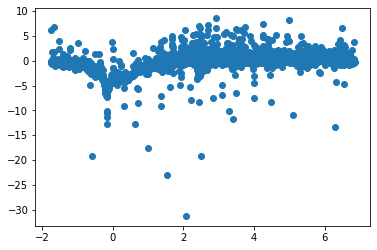

In [223]:
data = []
for root, dirs, files in os.walk(targetdir + 'KMT-2019-BLG-' + eventid_list[num]):
    for f in files:
        if 'V' not in f:
            p = re.compile('___')
            file = open(f'{targetdir}KMT-2019-BLG-{eventid_list[num]}/{f}', 'r+')
            lines = [line for line in file.readlines() if p.search(line) is None]
            file.seek(0)
            file.truncate(0)
            file.writelines(lines)
            file.close()

            data.append(np.loadtxt(f'{targetdir}KMT-2019-BLG-{eventid_list[num]}/{f}'))
data = np.vstack(data)
data = data[np.argsort(data[:, 0])]
params = np.loadtxt(targetdir + 'params.csv', delimiter=',', skiprows=1)
params = params[params[:, 0]==int(eventid_list[num])].flatten()
data[:, 0] = (data[:, 0] - params[1]) / params[2]
data[:, 3] = (data[:, 3] - params[-1]) / 0.2
plt.scatter(data[:, 0], data[:, 3])
plt.show()

tensor(0.5000) 0.48040819309479266
0.7437993654425611


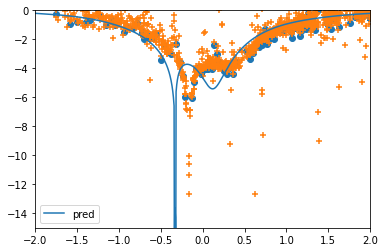

In [224]:
print(q[num], 10**sample[0, 2])
print(10**sample[0, -1])
plt.xlim(-2, 2)
plt.ylim(-15, 0)
plt.scatter(X_even[num, :, 0], X_even[num, :, 1], marker='o')
plt.scatter(data[:, 0], data[:, 3], marker='+')
# plt.plot(lc[:, 0], lc[:, 1], label='actual', color='red')
plt.plot(lc_pred[:, 0], lc_pred[:, 1], label='pred')
plt.legend()
plt.show()